In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model
import pandas as pd

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] < 2, \
    "This notebook does not worl for TensorFlow 2.0"

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
from tensorflow.keras import *

import os
import pickle
# from numba import jit

TensorFlow version:  1.13.1


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [3]:
grid = 16
# training data : 100,000 signal samples and 100,000 bkg samples
traindata_sig = np.load('data/jetImages_signal_littleoverlap_train.npz')
traindata_bkg = np.load('data/jetImages_bkg_littleoverlap_train.npz')
train={}
for key in traindata_sig.files[:-1]:
    if (key == 'jetImages'):
        train[key] = np.concatenate((traindata_sig[key], traindata_bkg[key]),axis=1).reshape(
        (len(traindata_sig[key])+len(traindata_bkg[key])), grid, grid, 1)
    else:
        train[key] = np.concatenate((traindata_sig[key], traindata_bkg[key]),axis=1).reshape(
        (len(traindata_sig[key])+len(traindata_bkg[key])), traindata_sig[key].shape[1])
        
# testing data : 20,000 signal samples and 10,000 bkg samples
testdata_sig = np.load('data/jetImages_signal_littleoverlap_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_littleoverlap_test.npz')
test={}
for key in testdata_sig.files[:-1]:
    if (key == 'jetImages'):
        test[key] = np.concatenate((testdata_sig[key], testdata_bkg[key]),axis=1).reshape(
        (len(testdata_sig[key])+len(testdata_bkg[key])), grid, grid, 1)
    else:
        test[key] = np.concatenate((testdata_sig[key], testdata_bkg[key]),axis=1).reshape(
        (len(testdata_sig[key])+len(testdata_bkg[key])), testdata_sig[key].shape[1])

In [4]:
#n_train = len(train['labels'])
#n_test = len(test['labels'])
#train['jetImages'] = train['jetImages'].reshape(n_train, grid, grid, 1)
#test['jetImages'] = test['jetImages'].reshape(n_test, grid, grid, 1)
np.savez('data/jetImagesTrain', jetImages = train['jetImages'], thetalab = train['thetalab'], radiilab = train['radiilab'], zlab = train['zlab'], labels = train['labels'])
np.savez('data/jetImagesTest', jetImages = test['jetImages'], thetalab = test['thetalab'], radiilab = test['radiilab'], zlab = test['zlab'], labels = test['labels'])

In [5]:
data_train = np.load('data/jetImagesTrain.npz')
data_test = np.load('data/jetImagesTest.npz')
# feat_all = [key for key in data_train.keys()]
# feat_all.remove('labels')

Build DNN:

In [6]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1), name = 'input')
    x = layers.Conv2D(32, (5, 5), activation='relu', name = "conv1", padding = 'same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv2', padding = 'same')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', name = 'conv3', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'dense1')(x)
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [7]:
CNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [8]:
X_batch = data_train['jetImages'][:10]
Y_batch = data_train['labels'][:10]
example_result = CNN.predict(x = X_batch)
results = CNN.evaluate(x = X_batch, y = Y_batch )
print(results)

10/10 [==============================] - 0s 6ms/sample - loss: 0.6931 - mean_squared_error: 0.2500 - binary_crossentropy: 0.6931 - acc: 0.4000
[0.6930874586105347, 0.24997012, 0.69308746, 0.4]


Now train!

In [9]:
checkpoint_path = "model/CNN2D.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)
EPOCHS = 500
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(data_train['jetImages'], data_train['labels'],
                           epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                           callbacks=[early_stop, model_checkpoint])
CNN.save(checkpoint_path)

Train on 160000 samples, validate on 40000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
159904/160000 [============================>.] - ETA: 0s - loss: 0.0713 - mean_squared_error: 0.0197 - binary_crossentropy: 0.0713 - acc: 0.9743
Epoch 00001: val_loss improved from inf to 0.05971, saving model to model/CNN2D.h5
160000/160000 [==============================] - 80s 498us/sample - loss: 0.0713 - mean_squared_error: 0.0197 - binary_crossentropy: 0.0713 - acc: 0.9743 - val_loss: 0.0597 - val_mean_squared_error: 0.0162 - val_binary_crossentropy: 0.0597 - val_acc: 0.9791
Epoch 2/500
159936/160000 [============================>.] - ETA: 0s - loss: 0.0530 - mean_squared_error: 0.0144 - binary_crossentropy: 0.0530 - acc: 0.9811
Epoch 00002: val_loss improved from 0.05971 to 0.04705, saving model to model/CNN2D.h5
160000/160000 [==============================] - 79s 497us/sample - loss: 0.0530 - mean_squared_error: 0.0144 - binary_crossentropy: 0.0530 - acc: 0.9811 - val

Epoch 18/500
159936/160000 [============================>.] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.0067 - binary_crossentropy: 0.0246 - acc: 0.9913
Epoch 00018: val_loss did not improve from 0.03914
160000/160000 [==============================] - 79s 492us/sample - loss: 0.0246 - mean_squared_error: 0.0067 - binary_crossentropy: 0.0246 - acc: 0.9913 - val_loss: 0.0431 - val_mean_squared_error: 0.0108 - val_binary_crossentropy: 0.0431 - val_acc: 0.9865
Epoch 19/500
159936/160000 [============================>.] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.0063 - binary_crossentropy: 0.0232 - acc: 0.9920
Epoch 00019: val_loss did not improve from 0.03914
160000/160000 [==============================] - 79s 493us/sample - loss: 0.0232 - mean_squared_error: 0.0062 - binary_crossentropy: 0.0232 - acc: 0.9920 - val_loss: 0.0445 - val_mean_squared_error: 0.0112 - val_binary_crossentropy: 0.0445 - val_acc: 0.9855
Epoch 20/500
159968/160000 [============================>.] - ETA:

Load best weights.

In [10]:
best_model = keras.models.load_model('model/CNN2D.h5')
best_model.summary()
results = best_model.evaluate(data_test['jetImages'], data_test['labels'], verbose = 1)
print(results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16, 16, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                131136    
__________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [11]:
predict = best_model.predict(data_test['jetImages'])

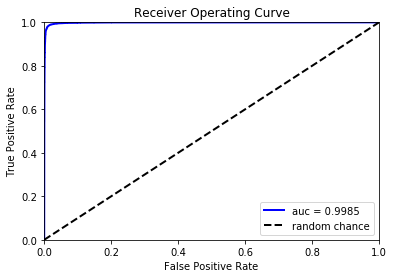

In [12]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(data_test['labels'][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

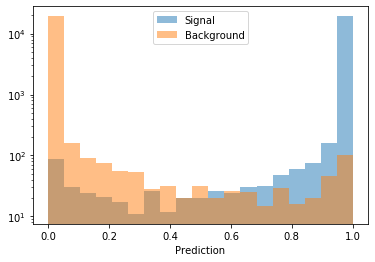

In [13]:
sig = predict[data_test['labels'][:,1]==1][:,1]
bkg = predict[data_test['labels'][:,0]==1][:,1]

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')
# plt.ylim(0,25000)
plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.show()

In [14]:
def build_model():
    input1 = layers.Input(shape = (grid, grid,1))
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name = 'conv1')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv2')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', padding='same', name = 'conv3')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool2x2_1')(x)
    x1 = layers.Flatten(name = 'flatten')(x)
    input2 = layers.Input(shape=(1,))
    input3 = layers.Input(shape=(2,))
    input4 = layers.Input(shape=(1,))
    x = layers.concatenate(inputs = [x1, input2, input3, input4], axis=-1, name='concat')
    x = layers.Dense(64, activation='relu', name = 'relu1')(x)
    x = layers.Dense(128, activation='relu', name = 'relu2')(x)    
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=[input1, input2, input3, input4], outputs=output)
    
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

In [15]:
CNN_XAUG = build_model()

In [16]:
X_batch1 = data_train['jetImages'][:10]
X_batch2 = data_train['thetalab'][:10]
X_batch3 = data_train['radiilab'][:10]
X_batch4 = data_train['zlab'][:10]
Y_batch = data_train['labels'][:10]
example_result = CNN_XAUG.predict(x = [X_batch1,X_batch2,X_batch3,X_batch4])
results = CNN_XAUG.evaluate(x = [X_batch1,X_batch2,X_batch3,X_batch4], y = Y_batch )
print(results)

10/10 [==============================] - 0s 8ms/sample - loss: 0.6960 - mean_squared_error: 0.2514 - binary_crossentropy: 0.6960 - acc: 0.0000e+00
[0.6959754228591919, 0.25141412, 0.6959754, 0.0]


In [17]:
checkpoint_path = "model/CNN2D_XAUG.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)  #save_freq='epoch',   
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN_XAUG.fit([data_train['jetImages'], data_train['thetalab'], data_train['radiilab'], data_train['zlab']], data_train['labels'],
                        epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                        callbacks=[early_stop, model_checkpoint])
CNN_XAUG.save(checkpoint_path)

Train on 160000 samples, validate on 40000 samples
Epoch 1/50
159872/160000 [============================>.] - ETA: 0s - loss: 0.0221 - mean_squared_error: 0.0059 - binary_crossentropy: 0.0221 - acc: 0.9922
Epoch 00001: val_loss improved from inf to 0.00888, saving model to model/CNN2D_XAUG.h5
160000/160000 [==============================] - 87s 544us/sample - loss: 0.0221 - mean_squared_error: 0.0059 - binary_crossentropy: 0.0221 - acc: 0.9922 - val_loss: 0.0089 - val_mean_squared_error: 0.0022 - val_binary_crossentropy: 0.0089 - val_acc: 0.9970
Epoch 2/50
159968/160000 [============================>.] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0021 - binary_crossentropy: 0.0091 - acc: 0.9973
Epoch 00002: val_loss improved from 0.00888 to 0.00820, saving model to model/CNN2D_XAUG.h5
160000/160000 [==============================] - 87s 542us/sample - loss: 0.0091 - mean_squared_error: 0.0021 - binary_crossentropy: 0.0091 - acc: 0.9973 - val_loss: 0.0082 - val_mean_squared_error: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



159936/160000 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0070 - acc: 0.9979
Epoch 00022: val_loss did not improve from 0.00673
160000/160000 [==============================] - 86s 538us/sample - loss: 0.0070 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0070 - acc: 0.9979 - val_loss: 0.0075 - val_mean_squared_error: 0.0019 - val_binary_crossentropy: 0.0075 - val_acc: 0.9974
Epoch 23/50
159904/160000 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9980
Epoch 00023: val_loss did not improve from 0.00673
160000/160000 [==============================] - 86s 538us/sample - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9980 - val_loss: 0.0075 - val_mean_squared_error: 0.0018 - val_binary_crossentropy: 0.0075 - val_acc: 0.9977
Epoch 24/50
117888/160000 [=====================>........] - ETA: 21s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



159872/160000 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9980
Epoch 00027: val_loss did not improve from 0.00653
160000/160000 [==============================] - 86s 537us/sample - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9980 - val_loss: 0.0078 - val_mean_squared_error: 0.0018 - val_binary_crossentropy: 0.0078 - val_acc: 0.9979
Epoch 28/50
159872/160000 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9981
Epoch 00028: val_loss did not improve from 0.00653
160000/160000 [==============================] - 86s 539us/sample - loss: 0.0069 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0069 - acc: 0.9981 - val_loss: 0.0069 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0069 - val_acc: 0.9980
Epoch 29/50
132736/160000 [=======================>......] - ETA: 13s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



159936/160000 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9980
Epoch 00032: val_loss did not improve from 0.00653
160000/160000 [==============================] - 86s 538us/sample - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9980 - val_loss: 0.0066 - val_mean_squared_error: 0.0015 - val_binary_crossentropy: 0.0066 - val_acc: 0.9981
Epoch 33/50
159904/160000 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9980
Epoch 00033: val_loss did not improve from 0.00653
160000/160000 [==============================] - 86s 536us/sample - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9980 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0068 - val_acc: 0.9980
Epoch 34/50
159936/160000 [============================>.] - ETA: 0s - loss: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



159904/160000 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0067 - acc: 0.9980
Epoch 00038: val_loss did not improve from 0.00641
160000/160000 [==============================] - 86s 540us/sample - loss: 0.0067 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0067 - acc: 0.9980 - val_loss: 0.0065 - val_mean_squared_error: 0.0015 - val_binary_crossentropy: 0.0065 - val_acc: 0.9980
Epoch 39/50
159872/160000 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0015 - binary_crossentropy: 0.0067 - acc: 0.9981
Epoch 00039: val_loss did not improve from 0.00641
160000/160000 [==============================] - 86s 538us/sample - loss: 0.0067 - mean_squared_error: 0.0015 - binary_crossentropy: 0.0067 - acc: 0.9981 - val_loss: 0.0065 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0065 - val_acc: 0.9980
Epoch 40/50
 60032/160000 [==========>...................] - ETA: 50s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



159968/160000 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9981
Epoch 00043: val_loss did not improve from 0.00641
160000/160000 [==============================] - 86s 537us/sample - loss: 0.0068 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0068 - acc: 0.9981 - val_loss: 0.0068 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0068 - val_acc: 0.9981
Epoch 44/50
159872/160000 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0067 - acc: 0.9980
Epoch 00044: val_loss did not improve from 0.00641
160000/160000 [==============================] - 85s 534us/sample - loss: 0.0067 - mean_squared_error: 0.0016 - binary_crossentropy: 0.0067 - acc: 0.9980 - val_loss: 0.0069 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.0069 - val_acc: 0.9981
Epoch 45/50
 82080/160000 [==============>...............] - ETA: 39s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
best_model = keras.models.load_model('model/CNN2D_XAUG.h5')
best_model.summary()
results = best_model.evaluate([data_train['jetImages'], data_train['thetalab'], data_train['radiilab'], data_train['zlab']], data_train['labels'], verbose = 1)
print(results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 16, 32)   9248        conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 16, 16, 32)   4128        conv2[0][0]                      
__________________________________________________________________________________________________
maxpool2x2

In [19]:
predict_XAUG = best_model.predict([data_test['jetImages'], data_test['thetalab'], data_test['radiilab'], data_test['zlab'] ])

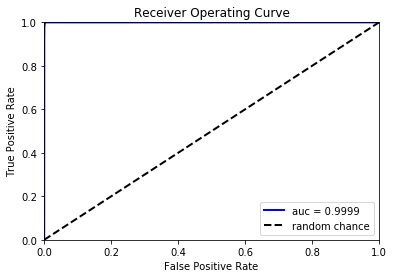

In [20]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(data_test['labels'][:,1], predict_XAUG[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

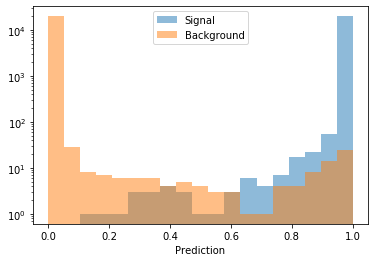

In [21]:
sig = predict_XAUG[data_test['labels'][:,1]==1][:,1]
bkg = predict_XAUG[data_test['labels'][:,0]==1][:,1]

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')
# plt.ylim(0,25000)
plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.show()